In [1]:
import cv2
import os
import pandas as pd

import torch
from torch import nn
from PIL import Image
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms, datasets 
from torchmetrics.classification import BinaryAccuracy
from torchmetrics import ConfusionMatrix

import copy
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from efficientnet_pytorch import EfficientNet

In [2]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, basePath, low_res, high_res, EPOCHS, LR, batchSize, ):
        self.trainPath = basePath + "train/"
        self.testPath = basePath + "test/"
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.bs = batchSize
        self.low_res = (low_res, low_res)
        self.high_res = (high_res, high_res)
        self.train_validate_percent = 0.95
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Configuration(basePath="../datasets/Retinal_OCT/", low_res=32, high_res=128, EPOCHS=500, LR=0.0001, batchSize=64 )

In [3]:
class SRGAN_Dataset(Dataset):
    
    # Init has to find all paths to image and labels
    def __init__(self, root_dir, low_res=(32,32), transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.low_res = low_res
        
        # Classifications of the objects
        self.definitions = os.listdir(self.root_dir)
        
        data = []
        # Go through each defination and add each image path to the csv
        for label in self.definitions:
            label_path = self.root_dir + label + "/"
            
            for image in os.listdir(label_path):
                
                # Check if file is of an image type
                if image.split('.')[-1] not in ["png", "jpg", "jpeg"]:
                    continue
                
                # If it is, then append the path to the image as well as the label given by the folder
                data.append({
                    'path': label_path + image,
                    'label': self.definitions.index(label)
                })
        
        # Save to a dataframe
        self.csv = pd.DataFrame(data)

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        
        # Extract the path and label of a datapoint
        img_path = self.csv.iloc[idx]['path']
        label = self.csv.iloc[idx]['label']

        # Open the image and ensure 3 channels
        img_high = Image.open(img_path)
        img_high = img_high.convert('RGB')

        if self.transform:
            img_high = self.transform(img_high)
            
        img_low = transforms.Resize(size=self.low_res)(img_high)

        return (img_low, img_high, label)

In [4]:
# train = SRGAN_Dataset(config.trainPath, low_res=config.low_res, transform=train_transform)
# x, y, l = train.__getitem__(5)
# x.shape, y.shape, l

In [5]:
# Using transforms to augment data by randomizing in multiple ways, rotation, translation, and scaling
train_transform = transforms.Compose([
                                        transforms.Resize(size=config.high_res),
                                        # transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Test and Validation transformations did not have the same modifications
test_transform = transforms.Compose([
                                        transforms.Resize(size=config.high_res),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [6]:
# Creates the initial ImageFolder dataset from the training path
train = SRGAN_Dataset(config.trainPath, low_res=config.low_res, transform=train_transform)

# Creates the initial ImageFolder dataset from the testing path
test = SRGAN_Dataset(config.testPath, low_res=config.low_res, transform=test_transform)

# Prints infomation about the datasets
print("\nTraining Dataset\n", len(train))
print("\nTesting Dataset\n", len(test))


Training Dataset
 19112

Testing Dataset
 930


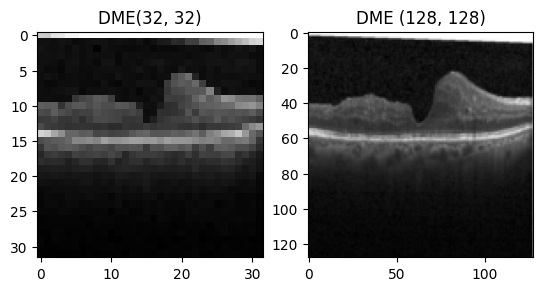

In [7]:
# Precalculated the number each class to ensure a balanced dataset
classTrainCount = {"DME":10847, "DRUSEN":8265} 

# Sets string definitions based on integer values
definitions = {0:"DME", 1:"DRUSEN"}

img_low, img_high, label = train[0]
img_low = np.array(img_low.permute(1,2,0))
img_high = np.array(img_high).transpose((1, 2, 0))

# Normalize the pixel values to the range [0, 1] for visualization
img_low = (img_low - img_low.min()) / (img_low.max() - img_low.min())
img_high = (img_high - img_high.min()) / (img_high.max() - img_high.min())

# View some of the training data
fig, axes = plt.subplots(nrows=1, ncols=2)

# Plot the data on the subplots
axes[0].imshow(img_low)
axes[0].set_title(f"{definitions[label]}{config.low_res}")

axes[1].imshow(img_high)
axes[1].set_title(f"{definitions[label]} {config.high_res}")
plt.show()

In [8]:
# Create all three dataloaders for the training, validating, and testing datasets
trainLoader = DataLoader(train, batch_size=config.bs, shuffle=True, num_workers=0)
testLoader = DataLoader(test, batch_size=1, shuffle=False, num_workers=0)

In [9]:
class Residual(nn.Module):
    def __init__(self, num_channels, stride=1):
        super(Residual, self).__init__()
        self.num_channels = num_channels
        
        self.net = nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=stride),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            
            nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=stride),
            nn.LazyBatchNorm2d()
        )
        
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=stride)
        
    def forward(self, x):
        
        out = self.net(x)
        
        if self.num_channels != x.shape[1]:
            x = self.conv3(x)
        else:
            self.conv3 = None
            
        out += x 
        
        return out

In [10]:
class SR_Generator(nn.Module):
    def __init__(self, body_arch):
        super(SR_Generator, self).__init__()

        # The first convolutional layer (c1) with a 9x9 kernel, 64 filters, and PReLU activation
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
        )

        # The main body of the generator containing residual blocks (body_arch defines the structure)
        self.body = nn.Sequential()
        for i, b in enumerate(body_arch):
            self.body.add_module(f'b{i+2}', self.res_block(*b))
        

        # The second convolutional layer (c2) with a 3x3 kernel, 64 filters, and Batch Normalization
        self.c2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
        )

        # The third convolutional block (c3) containing two upsampling layers and the final output layer
        self.c3 = nn.Sequential(
            # First upsampling layer: 3x3 kernel, 256 filters, PixelShuffle, and PReLU activation
            nn.Conv2d(64, 256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),

            # Second upsampling layer: 3x3 kernel, 256 filters, PixelShuffle, and PReLU activation
            nn.Conv2d(64, 256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),

            # Final output layer: 9x9 kernel, 3 filters (RGB channels), and no activation
            nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        # Pass input through the first convolutional layer (c1)
        out = self.c1(x)
        
        # Pass the output through the residual blocks (body)
        x = self.body(out)

        # Pass the output through the second convolutional layer (c2)
        x = self.c2(x)

        # Add the skip connection from the output of c1
        x += out

        # Pass the output through the third convolutional block (c3) to generate the final image
        x = self.c3(x)

        return x

    # Function to create a residual block with a specified number of residuals and channels
    def res_block(self, num_residuals, num_channels):
        blk = []
        for i in range(num_residuals):
            blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

class PretrainGeneratorLoss(nn.Module):
    def __init__(self):
        super(PretrainGeneratorLoss, self).__init__()
        self.pre_train = True
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr):
        # Calculate the MSE loss between the super-resolved image and the high-resolution image
        content_loss = self.mse_loss(sr, hr)
        return content_loss
    
class GeneratorLoss(nn.Module):
    def __init__(self, content_weight=1e-3, adversarial_weight=1):
        super(GeneratorLoss, self).__init__()
        self.pre_train = False
        self.content_weight = content_weight
        self.adversarial_weight = adversarial_weight
        
        self.vgg19 = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1')
        self.vgg19 = nn.Sequential(*list(self.vgg19.features.children())[:35])
        self.vgg19 = self.vgg19.cuda() if torch.cuda.is_available() else self.vgg19
        self.vgg19.eval()
        
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

    def forward(self, sr, hr, discriminator_pred):
        # Calculate the content loss
        hr_features = self.vgg19(hr)
        sr_features = self.vgg19(sr)
        content_loss = self.mse_loss(sr_features, hr_features.detach())

        # Calculate the adversarial loss
        real_label = torch.ones(discriminator_pred.size())
        real_label = real_label.cuda() if torch.cuda.is_available() else real_label
        adversarial_loss = self.bce_loss(discriminator_pred, real_label)

        # Total generator loss
        total_loss = self.content_weight * content_loss + self.adversarial_weight * adversarial_loss
        return total_loss

In [11]:
class SR_Discriminator(nn.Module):
    def __init__(self, body_arch):
        super(SR_Discriminator, self).__init__()

        self.body = nn.Sequential()
        for i, b in enumerate(body_arch):
            self.body.add_module(f'b{i+2}', self.dis_block(*b, i))

        # Add the fully connected part before the final nn.Linear layer
        self.fc = nn.Sequential(
            nn.LazyLinear(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # Pass the output through the discriminator blocks (body)
        x = self.body(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Pass the output through the fully connected part
        x = self.fc(x)

        return x

    def dis_block(self, kernel_size, num_channels, stride, use_bn=True):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=kernel_size, stride=stride),
            nn.LazyBatchNorm2d() if use_bn else nn.Identity(),
            nn.LeakyReLU(0.2),
        )
    
    
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, real_pred, fake_pred):
        real_label = torch.ones(real_pred.size())
        fake_label = torch.zeros(fake_pred.size())

        if torch.cuda.is_available():
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()

        # Loss for real high-resolution images
        real_loss = self.bce_loss(real_pred, real_label)

        # Loss for generated high-resolution images
        fake_loss = self.bce_loss(fake_pred, fake_label)

        # Total discriminator loss
        total_loss = (real_loss + fake_loss) * 0.5
        return total_loss

In [12]:
Generator = SR_Generator( body_arch= [(5,64)]).to(config.device)
test_input = torch.rand(1,3,32,32).to(config.device)
print("Output Size:", Generator(test_input).shape, "\n")

Discriminator = SR_Discriminator(body_arch= [
    (3, 64, 1), (3, 64, 2),
    (3, 128, 1), (3, 128, 2),
    (3, 256, 1), (3, 256, 2),
    (3, 512, 1), (3, 512, 2)
]).to(config.device)
test_input = torch.rand(1,3,128,128).to(config.device)
print("Output Size:", Discriminator(test_input).shape, "\n")

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Output Size: torch.Size([1, 3, 128, 128]) 

Output Size: torch.Size([1, 1]) 



In [13]:
def visualize_images(lr_image, hr_image, fake_image, label, epoch, pre_train, show=True):
    
    lr_image = np.transpose(lr_image.cpu().numpy(), (1, 2, 0))
    hr_image = np.transpose(hr_image.cpu().numpy(), (1, 2, 0))
    fake_image = np.transpose(fake_image.cpu().numpy(), (1, 2, 0))
    
    p = "p" if pre_train else ""
    cv2.imwrite(f"progress/fk/{epoch}{p}.png", fake_image*255)
    
    
    if not os.path.exists(f"progress/hr/0.png"):
        cv2.imwrite(f"progress/hr/0.png", hr_image*255)
        cv2.imwrite(f"progress/lr/0.png", lr_image*255)
        

    if show:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs = axs.ravel()
        
        axs[0].imshow(lr_image, cmap='gray')
        axs[0].set_title('Low Resolution')

        axs[1].imshow(hr_image, cmap='gray')
        axs[1].set_title('High Resolution')

        axs[2].imshow(fake_image, cmap='gray')
        axs[2].set_title('Generated Image')

        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        fig.suptitle(definitions[label])
        plt.show()


def Train_SRGAN(Generator, Discriminator, Generator_Loss, Discriminator_Loss, TrainLoader, TestLoader, lr, EPOCHs):
    
    Generator.train()
    Discriminator.train()
    
    Gen_optimizer = torch.optim.Adam(Generator.parameters(), lr=lr)
    Dis_optimizer = torch.optim.Adam(Discriminator.parameters(), lr=lr)
    
    Metrics = {"Generator Loss": [0], "Discriminator Loss": [0]}
    
    for epoch in range(EPOCHs):
        
        genLossSum = 0
        disLossSum = 0

        # Iterates through dataloader
        for i, (low_res, high_res, labels) in enumerate(tqdm(TrainLoader)):
            
            # Moves inputs and outputs to GPU and makes the labels one-hot vectors
            low_res = low_res.to(config.device)
            high_res = high_res.to(config.device)
            
            # Model makes prediction which is passed into a loss function
            fake_img = Generator(low_res)
            
            if not Generator_Loss.pre_train:
                fake_result = Discriminator(fake_img)
                real_result = Discriminator(high_res)

                # Update Discriminator
                Dis_loss = Discriminator_Loss(real_result, fake_result)
                Dis_optimizer.zero_grad()
                Dis_loss.backward(retain_graph=True)
                Dis_optimizer.step()

            # Update Generator
            gen_loss_updators = [fake_img, high_res]
            if not Generator_Loss.pre_train:
                gen_loss_updators.append(Dis_loss.detach())
            
            Gen_loss = Generator_Loss(*gen_loss_updators)
            Gen_optimizer.zero_grad()
            Gen_loss.backward()
            Gen_optimizer.step()
            
            # Running Loss and accuracy
            genLossSum += Gen_loss.item()
            
            if not Generator_Loss.pre_train:
                disLossSum += Dis_loss.item()

            
        # Update metrics based on running loss and accuracy
        Metrics["Generator Loss"].append(genLossSum / len(TrainLoader))
        if not Generator_Loss.pre_train:
            Metrics["Discriminator Loss"].append(disLossSum / len(TrainLoader))
        
        print(f"Epoch {epoch+1} - Generator Loss: {Metrics['Generator Loss'][-1]}, Discriminator Loss: {Metrics['Discriminator Loss'][-1]}")
        
        if (epoch + 1) % 1 == 0:
            
            Generator.eval()
            for i, (low_res, high_res, labels) in enumerate(TestLoader):
                with torch.no_grad():
                    sample_lr = low_res[0].unsqueeze(0)
                    sample_hr = high_res[0].unsqueeze(0)
                    sample_fake = Generator(sample_lr.to(config.device))
                    visualize_images(sample_lr[0], sample_hr[0], sample_fake[0], labels[0].item(), epoch, Generator_Loss.pre_train, False)
                break
                
            Generator.train()
        

    return Generator, Discriminator

In [ ]:
Train_SRGAN(Generator, Discriminator, PretrainGeneratorLoss(), DiscriminatorLoss(), trainLoader, testLoader, config.lr, 30)

  0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
Train_SRGAN(Generator, Discriminator, GeneratorLoss(), DiscriminatorLoss(), trainLoader, testLoader, config.lr*0.1, 470)

In [ ]:
torch.save(Generator.state_dict(), 'generator_model.pth')
torch.save(Discriminator.state_dict(), 'discriminator_model.pth')